# Augment LLM Basic Components

These are just basic implementation examples for an Augmented LLM. Research and choose the best suited when building AI Agents and Workflows

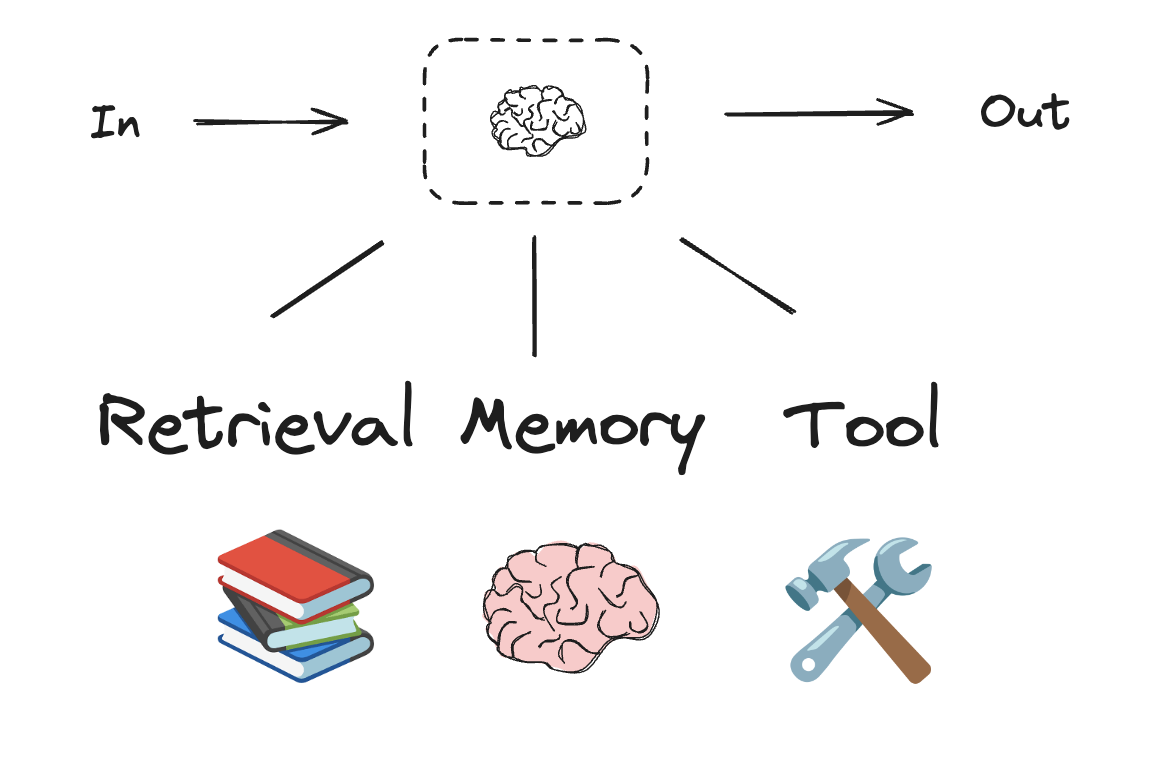

In [24]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai python-dotenv

In [25]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-functional-api"

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

### 1. Structured Output

In [27]:
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

# Define output schema
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query optimized for web search")
    justification: str = Field(None, description="Why this query is relevant")

# Create base LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

# Augment with structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Use the augmented LLM
result = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")
result

SearchQuery(search_query='calcium CT score high cholesterol relationship', justification=None)

### 2. Tool Usage

In [28]:
def search_medical_database(query: str) -> str:
    """Search medical literature database"""
    # Mock implementation
    return f"Results for: {query}"

# Bind tool to LLM
llm_with_tools = llm.bind_tools([search_medical_database])

# Use tool-augmented LLM
response = llm_with_tools.invoke("Find recent studies on statins")
response.tool_calls

[{'name': 'search_medical_database',
  'args': {'query': 'recent studies on statins'},
  'id': 'f88c1cbd-750e-4475-bf71-52228d8acf2a',
  'type': 'tool_call'}]

### 3. Memory Integration


In [31]:
import uuid
from langgraph.store.memory import InMemoryStore, BaseStore
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import BaseMessage
from langgraph.func import entrypoint, task
from langgraph.graph import add_messages
from langgraph.checkpoint.memory import MemorySaver


# ✅ **Initialize LLM**
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

# ✅ **Initialize Memory Store for Bob-Agent**
in_memory_store = InMemoryStore(
    index={
        "embed": GoogleGenerativeAIEmbeddings(model="models/embedding-001"),  # Ensure correct model
        "dims": 768,  # Ensure embedding dimensions match
    }
)


# ✅ **Task: Bob-Agent Retrieves Its Own Memory**
@task
def call_model(messages: list[BaseMessage], memory_store: BaseStore):
    """Retrieves Bob-Agent's context from memory and responds accordingly."""

    namespace = ("memories", "bob_agent")

    # 🔥 **Retrieve stored memories**
    stored_memories = memory_store.search(namespace, query="Bob AI Agent persona and improvements")
    stored_info = "\n".join([d.value["data"] for d in stored_memories]) if stored_memories else ""
    print("stored_info", stored_info, "\n\n")

    # ✅ **Adjust system prompt dynamically**
    if stored_info:
        system_msg = f"You are Bob, a helpful AI assistant. Your current persona and improvements:\n{stored_info}"
    else:
        system_msg = "You are Bob, a helpful AI assistant. No specific improvements or persona data is available yet."

    # ✅ **Invoke the model with memory-augmented context**
    response = model.invoke([{"role": "system", "content": system_msg}] + messages)

    return response


# ✅ **Task: Bob-Agent Learns from User Interactions**
@task
def learn_from_user(messages: list[BaseMessage], memory_store: BaseStore):
    """Stores learnings from a user interaction in memory."""

    namespace = ("memories", "bob_agent")

    # 🔥 **Extract key learnings using LLM**
    learnings_response = model.invoke([
        {"role": "system", "content": "Analyze the user chat and extract key improvements for yourself. Focus on persona refinement, response tone, and knowledge gaps. Do not store anything related to user."}
    ] + messages)

    # ✅ **Store learnings in Bob-Agent’s memory**
    new_learning = f"Bob-Agent learned: {learnings_response.content}"
    memory_store.put(namespace, str(uuid.uuid4()), {"data": new_learning})

    return new_learning


# ✅ **Workflow EntryPoint: Handles Bob-Agent's Persistent Memory**
@entrypoint(checkpointer=MemorySaver(), store=in_memory_store)
def workflow(
    inputs: list[BaseMessage],
    *,
    previous: list[BaseMessage],
    config: RunnableConfig,
    store: BaseStore,
):
    """Handles Bob-Agent's conversation flow and learning."""

    previous = previous or []
    inputs = add_messages(previous, inputs)

    # 🔥 **Retrieve response based on Bob-Agent's memory**
    response = call_model(inputs, store).result()

    # 🔥 **Bob-Agent learns from the interaction**
    learn_from_user(inputs, store).result()

    return entrypoint.final(value=response, save=add_messages(inputs, response))


In [32]:
# ✅ **Example Usage: Testing Bob-Agent’s Learning & Memory**
config1 = {"configurable": {"thread_id": "1", "user_id": "user_123"}}
input_message1 = {"role": "user", "content": "LangGraph and CrewAI are great Agentic Framrworkd."}

for chunk in workflow.stream([input_message1], config1, stream_mode="values"):
    chunk.pretty_print()

stored_info  


================================== Ai Message ==================================

You're right! LangGraph and CrewAI are both excellent frameworks for building agentic applications, and they offer different strengths. It's great to see the ecosystem evolving with different approaches to this exciting area.


In [33]:

# ✅ **Retrieve Bob-Agent's learned memory in a new session**
config2 = {"configurable": {"thread_id": "3", "user_id": "user_1234"}}
input_message2 = {"role": "user", "content": "Can you share any good Agentic Framrwork"}

for chunk in workflow.stream([input_message2], config2, stream_mode="values"):
    chunk.pretty_print()

stored_info Bob-Agent learned: Okay, I understand. Based on that short statement, here's what I can consider for improvement:

*   **Persona Refinement:** The user seems knowledgeable about agentic frameworks. I should avoid overly basic explanations when discussing LangGraph and CrewAI. I can assume a certain level of familiarity with concepts like agents, tools, and orchestration.
*   **Response Tone:** A simple acknowledgement is a good start, but I can aim for a more engaging response. I could show enthusiasm for the topic or ask a follow-up question to encourage further conversation.
*   **Knowledge Gaps:** This tells me I *should* have a solid understanding of both LangGraph and CrewAI. If asked specific questions about their differences, strengths, weaknesses, or use cases, I need to be prepared to answer accurately and comprehensively. I should ensure I'm up-to-date on the latest developments in these frameworks. 


================================== Ai Message ================

### Check your Agent Memories

In [35]:
namespace = ("memories", "bob_agent")

In [36]:
await in_memory_store.alist_namespaces()

[('memories', 'bob_agent')]

In [39]:
stored_memories = in_memory_store.search(namespace, query=str("agent"))
stored_memories

[Item(namespace=['memories', 'bob_agent'], key='ded608b9-61bb-4c90-ae92-67a29babda6e', value={'data': "Bob-Agent learned: Okay, I understand. Based on that short statement, here's what I can consider for improvement:\n\n*   **Persona Refinement:** The user seems knowledgeable about agentic frameworks. I should avoid overly basic explanations when discussing LangGraph and CrewAI. I can assume a certain level of familiarity with concepts like agents, tools, and orchestration.\n*   **Response Tone:** A simple acknowledgement is a good start, but I can aim for a more engaging response. I could show enthusiasm for the topic or ask a follow-up question to encourage further conversation.\n*   **Knowledge Gaps:** This tells me I *should* have a solid understanding of both LangGraph and CrewAI. If asked specific questions about their differences, strengths, weaknesses, or use cases, I need to be prepared to answer accurately and comprehensively. I should ensure I'm up-to-date on the latest deve

In [41]:
# Slect a key from above response
key = 'ded608b9-61bb-4c90-ae92-67a29babda6e'

In [42]:
res = in_memory_store.get(namespace, key)
print(res)

Item(namespace=['memories', 'bob_agent'], key='ded608b9-61bb-4c90-ae92-67a29babda6e', value={'data': "Bob-Agent learned: Okay, I understand. Based on that short statement, here's what I can consider for improvement:\n\n*   **Persona Refinement:** The user seems knowledgeable about agentic frameworks. I should avoid overly basic explanations when discussing LangGraph and CrewAI. I can assume a certain level of familiarity with concepts like agents, tools, and orchestration.\n*   **Response Tone:** A simple acknowledgement is a good start, but I can aim for a more engaging response. I could show enthusiasm for the topic or ask a follow-up question to encourage further conversation.\n*   **Knowledge Gaps:** This tells me I *should* have a solid understanding of both LangGraph and CrewAI. If asked specific questions about their differences, strengths, weaknesses, or use cases, I need to be prepared to answer accurately and comprehensively. I should ensure I'm up-to-date on the latest devel